## AAPL Stock Neural Network Prediction for 2019/2020

### Utilising the an LSTM MOdel for AAPL stock price predictions, 4 years of training data (2015-2019), 1 year of testing data (2019-2020)

In [1]:
#Imporing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from io import StringIO

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
#Reading in primary df
data = pd.read_csv('aapl_historical_data.csv')
data['Date'] = pd.to_datetime(data['Date'], format = '%b %d, %Y')

In [3]:
#Initial inspection
display(data.head())
display(data.tail())

,Date,Price,Open,High,Low,Vol.,Change %
0,2020-08-19,467.57,463.95,468.63,462.61,14.89M,1.15%
1,2020-08-18,462.25,457.74,463.99,456.10,26.41M,0.83%
2,2020-08-17,458.43,464.02,464.02,455.90,430.64K,-0.26%
3,2020-08-14,459.63,459.32,460.00,452.18,41.39M,-0.09%
4,2020-08-13,460.04,458.00,464.12,455.71,52.52M,1.77%


,Date,Price,Open,High,Low,Vol.,Change %
1256,2015-08-25,103.74,111.11,111.11,103.50,103.60M,0.60%
1257,2015-08-24,103.12,94.87,108.80,92.00,162.21M,-2.50%
1258,2015-08-21,105.76,110.43,111.90,105.64,128.28M,-6.12%
1259,2015-08-20,112.65,114.08,114.35,111.63,68.50M,-2.05%
1260,2015-08-19,115.01,116.10,116.52,114.68,48.29M,-1.28%


In [4]:
#Reversing row order for time linearity
data = data.iloc[::-1]
display(data.head())
display(data.tail())

,Date,Price,Open,High,Low,Vol.,Change %
1260,2015-08-19,115.01,116.10,116.52,114.68,48.29M,-1.28%
1259,2015-08-20,112.65,114.08,114.35,111.63,68.50M,-2.05%
1258,2015-08-21,105.76,110.43,111.90,105.64,128.28M,-6.12%
1257,2015-08-24,103.12,94.87,108.80,92.00,162.21M,-2.50%
1256,2015-08-25,103.74,111.11,111.11,103.50,103.60M,0.60%


,Date,Price,Open,High,Low,Vol.,Change %
4,2020-08-13,460.04,458.00,464.12,455.71,52.52M,1.77%
3,2020-08-14,459.63,459.32,460.00,452.18,41.39M,-0.09%
2,2020-08-17,458.43,464.02,464.02,455.90,430.64K,-0.26%
1,2020-08-18,462.25,457.74,463.99,456.10,26.41M,0.83%
0,2020-08-19,467.57,463.95,468.63,462.61,14.89M,1.15%


In [5]:
#Re-indexing 
data.index = range(1261)
display(data.head())
display(data.tail())

,Date,Price,Open,High,Low,Vol.,Change %
0,2015-08-19,115.01,116.10,116.52,114.68,48.29M,-1.28%
1,2015-08-20,112.65,114.08,114.35,111.63,68.50M,-2.05%
2,2015-08-21,105.76,110.43,111.90,105.64,128.28M,-6.12%
3,2015-08-24,103.12,94.87,108.80,92.00,162.21M,-2.50%
4,2015-08-25,103.74,111.11,111.11,103.50,103.60M,0.60%


,Date,Price,Open,High,Low,Vol.,Change %
1256,2020-08-13,460.04,458.00,464.12,455.71,52.52M,1.77%
1257,2020-08-14,459.63,459.32,460.00,452.18,41.39M,-0.09%
1258,2020-08-17,458.43,464.02,464.02,455.90,430.64K,-0.26%
1259,2020-08-18,462.25,457.74,463.99,456.10,26.41M,0.83%
1260,2020-08-19,467.57,463.95,468.63,462.61,14.89M,1.15%


In [6]:
#Checking all data are numeric
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1261 non-null   datetime64[ns]
 1   Price     1261 non-null   float64       
 2   Open      1261 non-null   float64       
 3   High      1261 non-null   float64       
 4   Low       1261 non-null   float64       
 5   Vol.      1261 non-null   object        
 6   Change %  1261 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 69.1+ KB


None

In [7]:
#Conversion to numeric
def vol_change(row):
    row = str(row)
    if row[-1] == 'M':
        row = row.replace('M', '')
        row = float(row) * 1000000
    elif row[-1] == 'K':
        row = row.replace('K', '')
        row = float(row) * 1000
    return row

def percent_change(row):
    row = str(row)
    if row[-1] == '%':
        row = row.replace('%', '')
    return row

data.iloc[:,5] = data.iloc[:,5].apply(vol_change)
data.iloc[:,6] = data.iloc[:,6].apply(percent_change)
display(data.head())
display(data.info())

,Date,Price,Open,High,Low,Vol.,Change %
0,2015-08-19,115.01,116.10,116.52,114.68,4.829e+07,-1.28
1,2015-08-20,112.65,114.08,114.35,111.63,6.85e+07,-2.05
2,2015-08-21,105.76,110.43,111.90,105.64,1.2828e+08,-6.12
3,2015-08-24,103.12,94.87,108.80,92.00,1.6221e+08,-2.50
4,2015-08-25,103.74,111.11,111.11,103.50,1.036e+08,0.60


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1261 non-null   datetime64[ns]
 1   Price     1261 non-null   float64       
 2   Open      1261 non-null   float64       
 3   High      1261 non-null   float64       
 4   Low       1261 non-null   float64       
 5   Vol.      1261 non-null   object        
 6   Change %  1261 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 69.1+ KB


None

In [8]:
#Checking of blanks
print(data[data['Vol.'] == '-'])

          Date  Price   Open   High    Low Vol. Change %
132 2016-02-27  96.95  96.95  96.95  96.95    -     0.04


In [9]:
#Finalising all data to float64
data = data.drop(data.index[132])
data['Vol.'] = data['Vol.'].astype('float')
data['Change %'] = data['Change %'].astype('float')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 0 to 1260
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1260 non-null   datetime64[ns]
 1   Price     1260 non-null   float64       
 2   Open      1260 non-null   float64       
 3   High      1260 non-null   float64       
 4   Low       1260 non-null   float64       
 5   Vol.      1260 non-null   float64       
 6   Change %  1260 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 78.8 KB
None


In [10]:
#Creating training data
data_training = data[data['Date'] < 'Aug 25, 2019']

In [11]:
display(data_training.head(1))
display(data_training.tail(1))

,Date,Price,Open,High,Low,Vol.,Change %
0,2015-08-19,115.01,116.1,116.52,114.68,48290000.0,-1.28


,Date,Price,Open,High,Low,Vol.,Change %
1011,2019-08-23,202.64,209.43,212.05,201.0,46880000.0,-4.62


In [12]:
#Creating testing data
data_testing = data[data['Date'] >= 'Aug 25, 2019']

In [13]:
display(data_testing.head(1))
display(data_testing.tail(1))

,Date,Price,Open,High,Low,Vol.,Change %
1012,2019-08-26,206.49,205.86,207.19,205.06,26070000.0,1.9


,Date,Price,Open,High,Low,Vol.,Change %
1260,2020-08-19,467.57,463.95,468.63,462.61,14890000.0,1.15


In [14]:
#Removal of unnessary date column from training data
training_data = data_training.drop('Date', axis=1)
display(training_data.head())

,Price,Open,High,Low,Vol.,Change %
0,115.01,116.10,116.52,114.68,48290000.0,-1.28
1,112.65,114.08,114.35,111.63,68500000.0,-2.05
2,105.76,110.43,111.90,105.64,128280000.0,-6.12
3,103.12,94.87,108.80,92.00,162210000.0,-2.50
4,103.74,111.11,111.11,103.50,103600000.0,0.60


In [15]:
#Scaling the data (0-1)
scaler = MinMaxScaler()
training_data_scaled = scaler.fit_transform(training_data)
print(training_data_scaled)

[[0.17406336 0.18539565 0.17524683 0.17967358 0.24481273 0.51058824]
 [0.15741198 0.17104702 0.15994358 0.157936   0.37878687 0.46529412]
 [0.10879842 0.14512005 0.14266573 0.11524482 0.77507458 0.22588235]
 ...
 [0.86290835 0.87363262 0.86022567 0.87042976 0.06761684 0.64941176]
 [0.86163833 0.87505327 0.86572638 0.86437175 0.0723235  0.58117647]
 [0.79235165 0.84834494 0.84894217 0.79488276 0.23546569 0.31411765]]


In [16]:
#Initialising empty lists
X_train = []
y_train = []

In [17]:
#Decisions made from previous 60 days of stock data

for i in range(60, training_data_scaled.shape[0]):
    X_train.append(training_data_scaled[i-60:i])
    y_train.append(training_data_scaled[i,0])

In [18]:
#Conversion to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [19]:
#Shape check
print(X_train.shape)
#951 rows, 60 columns, 6 dimensions

(951, 60, 6)


In [20]:
#Shape check
print(y_train.shape)
#951 rows

(951,)


In [21]:
#Building of LSTM model
#Input shape = 60,6 (X_train,shape[1] (60 columns), dimensions)
#Dropout = 0.2 = 20% of neural nodes will be randomly dropped to provide a better generalisation
regressor = Sequential()

regressor.add(LSTM(units=50, activation='relu', return_sequences = True, input_shape=(X_train.shape[1], 6)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=60, activation='relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=70, activation='relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units=70, activation='relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

In [22]:
#Model summary
display(regressor.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            11400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 70)            36680     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 70)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 70)                3

None

In [23]:
#Compiling of model
regressor.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
#Fitting the model
regressor.fit(X_train, y_train, epochs=10, batch_size=32)

Train on 951 samples
Epoch 1/10
951/951 [==============================] - 28s 30ms/sample - loss: 0.0892
Epoch 2/10
951/951 [==============================] - 17s 18ms/sample - loss: 0.0204
Epoch 3/10
951/951 [==============================] - 17s 18ms/sample - loss: 0.0157
Epoch 4/10
951/951 [==============================] - 17s 18ms/sample - loss: 0.0148
Epoch 5/10
951/951 [==============================] - 17s 18ms/sample - loss: 0.0127
Epoch 6/10
951/951 [==============================] - 17s 18ms/sample - loss: 0.0126
Epoch 7/10
951/951 [==============================] - 18s 19ms/sample - loss: 0.0117
Epoch 8/10
951/951 [==============================] - 18s 19ms/sample - loss: 0.0111
Epoch 9/10
951/951 [==============================] - 17s 18ms/sample - loss: 0.0103
Epoch 10/10
951/951 [==============================] - 17s 18ms/sample - loss: 0.0111


In [25]:
#Adding the last 60 days of the training set to the testing set as we are basing decisions off last 60 days
past_sixty_days = training_data.tail(60)

df = past_sixty_days.append(data_testing, ignore_index=True)
df = df.drop(['Date'], axis=1)
print(data_testing.head())

           Date   Price    Open    High     Low        Vol.  Change %
1012 2019-08-26  206.49  205.86  207.19  205.06  26070000.0      1.90
1013 2019-08-27  204.16  207.86  208.55  203.53  25900000.0     -1.13
1014 2019-08-28  205.53  204.10  205.72  203.32  15960000.0      0.67
1015 2019-08-29  209.01  208.50  209.32  206.65  21010000.0      1.69
1016 2019-08-30  208.74  210.16  210.45  207.20  21160000.0     -0.13


In [26]:
#Inspection of new df
df.head()

,Price,Open,High,Low,Vol.,Change %
0,175.07,176.23,177.99,174.99,27040000.0,-1.81
1,173.30,175.60,177.92,170.27,40400000.0,-1.01
2,179.64,175.44,179.83,174.52,30970000.0,3.66
3,182.54,184.28,184.99,181.14,29770000.0,1.61
4,185.22,183.08,185.47,182.15,22530000.0,1.47


In [35]:
#Scaling the testing inputs
test_inputs = scaler.transform(df)
display(test_inputs)

array([[ 0.59782685,  0.61251598,  0.60874471,  0.60950752,  0.10394432,
         0.47941176],
       [ 0.58533832,  0.60804091,  0.60825106,  0.57586772,  0.19250912,
         0.52647059],
       [ 0.63007126,  0.60690439,  0.62172073,  0.60615779,  0.12999669,
         0.80117647],
       ...,
       [ 2.59712129,  2.65676943,  2.62588152,  2.61157437, -0.07245184,
         0.57058824],
       [ 2.62407394,  2.61216082,  2.62566996,  2.61299979,  0.09976798,
         0.63470588],
       [ 2.6616101 ,  2.6562722 ,  2.6583921 ,  2.65939705,  0.02340073,
         0.65352941]])

In [28]:
#Initialising empty test lists and appending day ranges
X_test = []
y_test = []

for i in range(60, test_inputs.shape[0]):
    X_test.append(test_inputs[i-60:i])
    y_test.append(test_inputs[i,0])

In [29]:
#Conversion to arrays
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(249, 60, 6)
(249,)


In [30]:
#Predictions
y_pred = regressor.predict(X_test)

In [31]:
#Unscale the values
scaler.scale_

array([7.05566923e-03, 7.10328172e-03, 7.05218618e-03, 7.12707576e-03,
       6.62910176e-09, 5.88235294e-02])

In [32]:
#First column was divided by this value to bring the values between 0 and 1
scale = 1 / 7.05566923e-03
scale

141.73000000454954

In [33]:
#Bringing the scaled values back to actual values
y_pred = y_pred * scale
y_test = y_test * scale

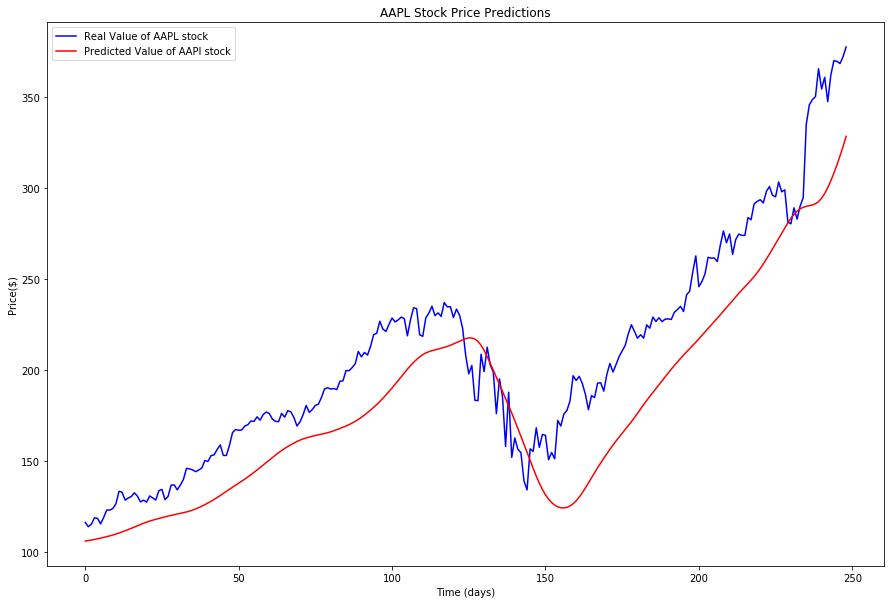

In [34]:
#Visualised Predicted Value of AAPL stock
plt.figure(figsize = (15,10))
plt.plot(y_test, color='blue', label='Real Value of AAPL stock')
plt.plot(y_pred, color='red', label = 'Predicted Value of AAPl stock')
plt.xlabel('Time (days)')
plt.ylabel('Price($)')
plt.legend()
plt.title('AAPL Stock Price Predictions')
plt.show()